# Data Wrangling: Join, Combine, Transformation

Import libraries we need

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

## Combining and Merging Datasets

Data contained in pandas objects can be combined together with the following built-in methods:
- `pandas.merge`: connects rows in DataFrames based on one or more keys. (Just like SQL or relational databases' `join` operations).
- `pandas.concat`: stacks objects along an axis.
- `combinbe_first`: splicing or overlapping data to fill in missing values with values from another.


*(얼마 전 진행되었던 Kaggle competition의 Feature Engineering에서 필수적으로 모든 단계에서 쓰였던 함수들이다.)*

### Database-Style DataFrame Joins

#### many-to-one merge

`Merge` or `join` operations combine data sets by **linking rows** using one or more `keys`. These operations are central to relational databases.   


In [3]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                    'data2': range(3)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [4]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


Let's do *many-to-one` merge.   
The data in **df1** has multiple rows labeled **a** and **b**, whereas **df2** has only one row for each value in the **key** column.

In [5]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


Note that I did not specify which column to join on. If not specified, `merge` uses the overlapping column names as the keys. This case, it was `key`.

Lets specify which column to join on using `on=key` parameter

In [6]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


Result is the same, but it's always better to specify which column to join `on`.

If there is no shared column names in each object, you can specify them: `left_on='lkey', right_on='rkey'`

In [7]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                    'data2': range(3)})
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


Notice that `'c'` and `'d'` are missing from the result. It's because by default `merge` does an `'inner'` join.    
Other possible options are `left, right, outer` join. 

Let's try `outer` join.

In [8]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


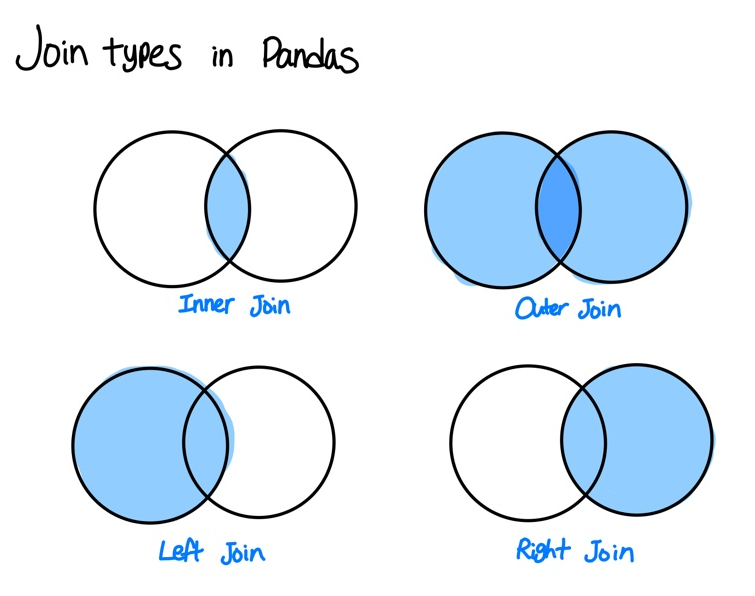

#### Many-to-many merge
Many-to-many merges have well-defined but not intuitive. Let's see the example with the left join.

In [10]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})
df2 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                    'data2': range(5)})
df1


,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [11]:
df2


,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [12]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


Many-to-many joins forms the Cartesian product of the rows.   
There were 3 **b** rows in the left DataFrame and 2 **b** in the right one, and 6 **b** rows in the result.

The join method only affects the distinct key values appearing 

In [13]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


#### Merge with multiple keys
To merge with multiple keys, pass a list of column names:

In [14]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


Think of the multiple keys as forming an array of tuples to be used as asingle join key to determine which key combinations will appear the result depending on the choice of merge method. (?) (p.319)

#### Overlapping column names
While you can address the overlap manually, `merge` has a `suffixes` option for specifying strings to append to overlapping names in the left and right DataFram.e

In [15]:
pd.merge(left, right, on='key1')
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


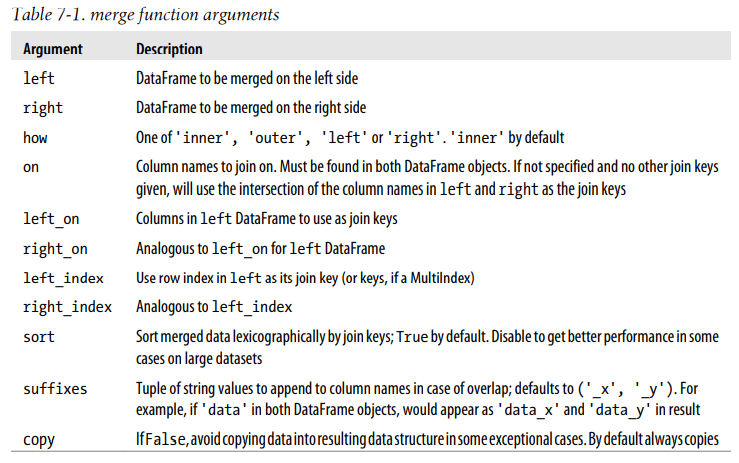

### Merging on Index

In some cases, the merge key in DataFrame is its index (병합하려는 키가 DataFrame의 색인일 경우). In this case, you can pass `left_index=True` or `right_index=True` (or both) to indicate that the index should be used as the merge key:


In [17]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                      'value': range(6)})
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])
left1


,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [18]:
right1


,group_val
a,3.5
b,7.0


In [19]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


The default merge method is to intersect the join keys, you can istead form the union of them iwth an outer join

In [20]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


#### Hierarchically-indexed data

For **hirerarchically-indexed data**, it's more complicated.  It's default to merge multiple keys.

In [21]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
                               'Nevada', 'Nevada'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index=[['Nevada', 'Nevada', 'Ohio', 'Ohio',
                              'Ohio', 'Ohio'],
                             [2001, 2000, 2000, 2000, 2001, 2002]],
                      columns=['event1', 'event2'])
lefth


,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [22]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

You need to indicate multiple columns to merge on as a list. For **duplicate index values,** you need to use `how='outer'` option.

In [23]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)


,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [24]:
pd.merge(lefth, righth, left_on=['key1', 'key2'],
         right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


#### Use indexes of both sides
It's also possible to use the indexes of both sides

In [25]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                     index=['a', 'c', 'e'],
                     columns=['Ohio', 'Nevada'])
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                      index=['b', 'c', 'd', 'e'],
                      columns=['Missouri', 'Alabama'])
left2


,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [26]:
right2


,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [27]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


#### Join
We can use `join` instance for merging by index.

In [34]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [35]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


Lastly, for simple index-on-index merges, you can pass a list of DataFrames to `join` as an alternative to using the more general `concat` function described below:

In [36]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                       index=['a', 'c', 'e', 'f'],
                       columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [39]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [40]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [37]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [38]:
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0
b,NaN,NaN,7.0,8.0,NaN,NaN
d,NaN,NaN,11.0,12.0,NaN,NaN
f,NaN,NaN,NaN,NaN,16.0,17.0


### Concatenating Along an Axis

(축 따라 이어붙이기)   
Another kind of data combination operation is alternatively referred to as **concatenation, binding, or stacking**. Numpy has a `concatenate` function for doing this with raw NumPy arrays:

In [41]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [42]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In the context of pandas objects such as **Series and DataFrame**, having labeled axes enable you to further generalize array concatenation.   

Things we need to remember:   
- If the objects are indexed differently on the other axes, should the collection of axes be unioned or intersected?
- Do the groups need to be identifiable in the resulting object?
- Does the concatenation axis matter at all?


The `concat` function in pandas provides a consistent way to address each of these concerns.   

Let's see a number of examples to check how it works.

In [29]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = pd.Series([5, 6], index=['f', 'g'])

In [44]:
s1

a    0
b    1
dtype: int64

In [45]:
s2

c    2
d    3
e    4
dtype: int64

In [46]:
s3

f    5
g    6
dtype: int64

Calling `concat` with these object in a list glues together to values and the indexes

In [43]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

By default, `concat` works with `axis=0` which produces another `Series`. If you pass `axis=1`,  the result will instead be a `DataFrame`.

In [31]:
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In this case there is no overlap on the other axis so you got the union (`outer` join), but you can instead intersect them by passing `join='inner'`.

In [47]:
s4 = pd.concat([s1, s3])

In [48]:
s4

a    0
b    1
f    5
g    6
dtype: int64

In [49]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [50]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,1


option `f` and `g` disappeared because of the `join='inner'` option.

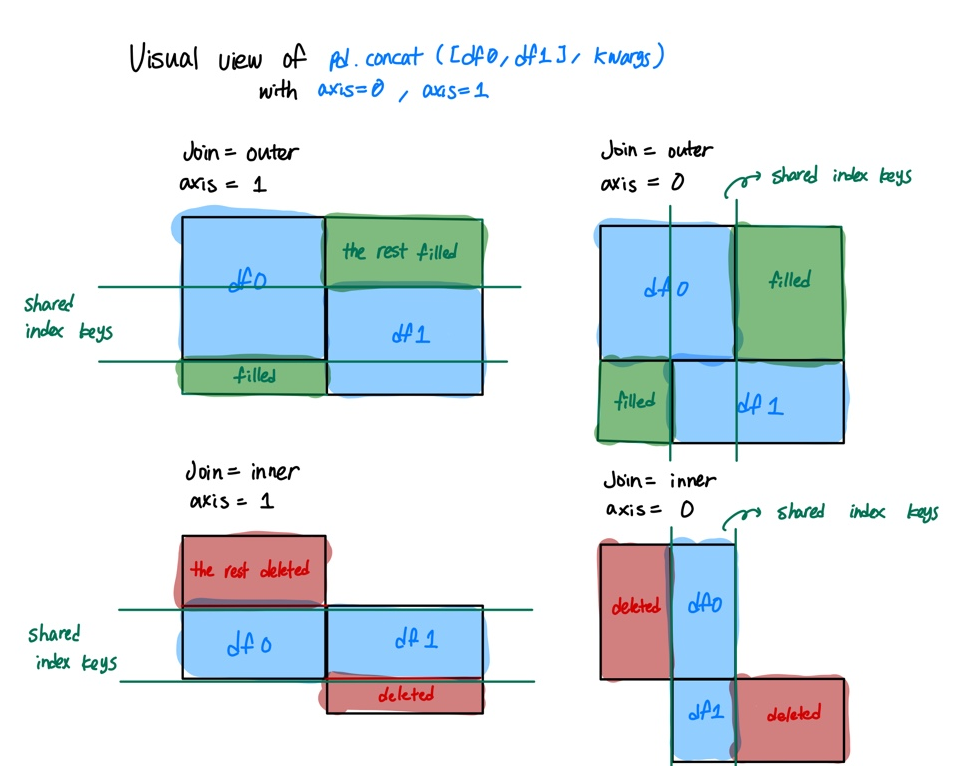

You can also specify the axes to be used on the other axes with `join_axes`:

In [52]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

TypeError: ignored

`join_axes` has been deprecated:   
`Deprecated since version 0.25.0.`

One issue is that the concatenated pieces are not identifiable in the result.   
To create a hierarchical index on the concatenation aixs, use the `keys` argument.   

(Series를 이어붙이기 전의 개별 Series를 구분할 수 없는 문제: 이어붙인 축에 대해 계층적 색인을 생성하여 식별 가능하도록 한다 -> `key` 인자를 사용한다.)

In [54]:
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [55]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


In the case of combining Series along `axis=1`, the `keys` befome the DataFrame column headers.

In [56]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


The same logic extends to DataFrame objects:

In [57]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
                   columns=['one', 'two'])
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
                   columns=['three', 'four'])
df1

,one,two
a,0,1
b,2,3
c,4,5


In [58]:
df2

,three,four
a,5,6
c,7,8


In [59]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

If you pass a dict of objects instead of a list, the dict's keys will be used for the `keys`.

In [60]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

There are additional arguments to handle the hierarchical index

In [61]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
          names=['upper', 'lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

Lastly, if the row index is not meaningful in the context of the analysis then what should we do?

In [62]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df1

,a,b,c,d
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221


In [63]:
df2

,b,d,a
0,0.274992,0.228913,1.352917
1,0.886429,-2.001637,-0.371843


Then we can do `ignore_index=True`.

In [64]:
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
3,1.352917,0.274992,NaN,0.228913
4,-0.371843,0.886429,NaN,-2.001637


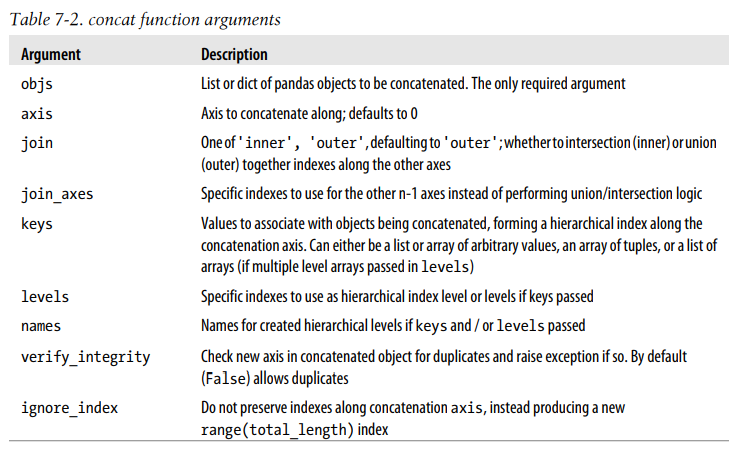

### Combining Data with Overlap

(겹치는 데이터 합치기)

There is more situations that can't be expressed as either a merge or concatenation operation. You may have two datasets whose indexes overlap in full or part.

In this situation, you can consider Numpy's `where` function to express vectorized `if-else`.

In [65]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [66]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [67]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Sereis has a `combine_first` method, which performs the same operation + data alignment

In [68]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

`combine_first` naturally does the same thing column by column, so what you can do is `patching` missing data in the calling object with data from the object you pass:

In [69]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                    'b': [np.nan, 2., np.nan, 6.],
                    'c': range(2, 18, 4)})
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
                    'b': [np.nan, 3., 4., 6., 8.]})
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [70]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## Conclusion